## Import

In [1]:
import pickle
import matplotlib.pyplot as plt
import warnings

from config import CONFIG
from easydict import EasyDict

from env.env_f import *
from state.state import *
from agent.PPOAgent_ms import *
from models.CTTS import *
from trainer.nonEpisodic import *
from trainer.Episodic import *
from utils.setDevice import *
from utils.timestepRelated import *
from visualization.methods import *

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load

In [3]:
with open('../data/processed/kospi200_ffill_clean_version.pkl', 'rb') as f:
    df = pickle.load(f)

df.head(5)

,date,time,open,high,low,close,prevClose,vol
2010-02-16 09:01:00,20100216,901,207.55,207.65,207.50,207.60,207.5,3985.0
2010-02-16 09:02:00,20100216,902,207.60,207.65,207.25,207.55,207.5,5095.0
2010-02-16 09:03:00,20100216,903,207.55,207.80,207.50,207.60,207.5,2175.0
2010-02-16 09:04:00,20100216,904,207.55,207.85,207.55,207.80,207.5,1301.0
2010-02-16 09:05:00,20100216,905,207.80,208.15,207.80,208.05,207.5,3870.0


## Set State info • scaler

In [4]:
target_values = ['open', 'high', 'low', 'close', 
                'vol','return_5', 'return_10', 'volume_change', 'ema_5', 
                'ema_20', 'ema_cross', 'cci', 'sar', '%K', 
                # '%D', 'roc', 'rsi', 'obv', 'ad_line', 
                'bb_upper', 'bb_lower', 'bb_width', 'atr', 'gap_size']

scaler = RobustScaler()

## Set Env info 

In [5]:
train_valid_timestep = split_date_ranges_by_group(df.index[:50000])
train_valid_timestep 

[(('2010-02-16', '2010-03-22'), ('2010-03-23', '2010-03-25')),
 (('2010-03-26', '2010-04-28'), ('2010-04-29', '2010-05-03')),
 (('2010-05-04', '2010-06-09'), ('2010-06-10', '2010-06-14')),
 (('2010-06-15', '2010-07-19'), ('2010-07-20', '2010-07-22')),
 (('2010-07-23', '2010-08-27'), ('2010-08-30', '2010-09-01'))]

In [6]:
# train_valid_timestep = [(('2010-02-16', '2010-02-17'), ('2010-02-22', '2010-02-23')),
#                         (('2010-02-23', '2010-02-24'), ('2010-03-02', '2010-03-03')),
#                         (('2010-03-03', '2010-03-04'), ('2010-03-09', '2010-03-10')),
#                         (('2010-03-10', '2010-03-16'), ('2010-03-16', '2010-03-17')),
#                         (('2010-03-17', '2010-03-18'), ('2010-03-26', '2010-03-27'))]

In [ ]:
# 
execution_strength = CONFIG.MAX_CONTRACT 
action_space = list(range(-execution_strength, execution_strength+1))
n_actions = len(action_space)
device = get_device() # torch.device("cpu")  

CONFIG.INPUT_DIM = len(target_values)
CONFIG.REWARD_FTN = risk_adjusted_pnl_reward
CONFIG.DONE_FTN = is_day_changed
CONFIG.TRAIN_VALID_TIMESTEP = train_valid_timestep
CONFIG.SCALER = scaler

In [8]:
state =  State(target_values)

model = MultiStatePV(
    input_dim=CONFIG.INPUT_DIM,
    agent_input_dim=CONFIG.AGENT_INPUT_DIM,
    embed_dim=CONFIG.EMBED_DIM,
    kernel_size=CONFIG.KERNEL_SIZE,
    stride=CONFIG.STRIDE,
    action_size=CONFIG.N_ACTIONS,
    device=device,
    agent_hidden_dim=CONFIG.AGENT_HIDDEN_DIM,
    agent_out_dim=CONFIG.AGENT_OUT_DIM,
    fusion_hidden_dim=CONFIG.FUSION_HIDDEN_DIM,
    num_layers=CONFIG.NUM_LAYERS,
    num_heads=CONFIG.NUM_HEADS,
    d_ff=CONFIG.D_FF,
    dropout=CONFIG.DROPOUT
)

agent = PPOAgent(
    action_space=CONFIG.ACTION_SPACE,
    n_actions=CONFIG.N_ACTIONS,
    model=model,
    value_coeff=CONFIG.VALUE_COEFF,
    entropy_coeff=CONFIG.ENTROPY_COEFF,
    clip_eps=CONFIG.CLIP_EPS,
    gamma=CONFIG.GAMMA,
    lr=CONFIG.LR,
    batch_size=CONFIG.BATCH_SIZE,
    epoch=CONFIG.EPOCH,
    device=device
)

== [0] interval training ===========================
Robust Scaling Completed.
Robust Scaling Completed.
>>>> Train : ('2010-02-16', '2010-03-22')
[0|Train] Ep 001 | info:  | Maintained for: 100 | Reward:  -20 | Loss:  0.223 | Pos(short/hold/long): 53% / 5% / 42% | Strength: 2.50 |
[0|Train] Ep 002 | info:  | Maintained for: 200 | Reward:  -18 | Loss:  0.363 | Pos(short/hold/long): 43% / 10% / 47% | Strength: 2.23 |
[0|Train] Ep 003 | info:  | Maintained for: 300 | Reward:  -53 | Loss:  0.790 | Pos(short/hold/long): 43% / 15% / 42% | Strength: 2.14 |
[0|Train] Ep 005 | info:  | Maintained for: 416 | Reward:  -20 | Loss:  0.250 | Pos(short/hold/long): 37% / 14% / 49% | Strength: 2.29 |
[0|Train] Ep 006 | info:  | Maintained for: 516 | Reward:  -21 | Loss:  0.299 | Pos(short/hold/long): 40% / 12% / 48% | Strength: 2.27 |
[0|Train] Ep 007 | info:  | Maintained for: 616 | Reward:  -26 | Loss:  0.495 | Pos(short/hold/long): 43% / 9% / 48% | Strength: 2.21 |
[0|Train] Ep 009 | info:  | Maint

c:\Users\smlee\Desktop\python\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\smlee\Desktop\python\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0|Valid] Ep 001 | info:  | Maintained for: 100 | Reward:  -15 | Pos(short/hold/long): 19% / 3% / 78% | Strength: 1.18 |
[0|Valid] Ep 002 | info:  | Maintained for: 200 | Reward:  -18 | Pos(short/hold/long): 38% / 2% / 60% | Strength: 1.19 |
[0|Valid] Ep 003 | info:  | Maintained for: 300 | Reward:  -15 | Pos(short/hold/long): 44% / 0% / 56% | Strength: 1.22 |
[0|Valid] Ep 004 | info: done | Maintained for: 316 | Reward:   -5 | Pos(short/hold/long): 38% / 0% / 62% | Strength: 1.25 |
[0|Valid] Ep 005 | info:  | Maintained for: 416 | Reward:  -45 | Pos(short/hold/long): 33% / 2% / 65% | Strength: 1.28 |
[0|Valid] Ep 006 | info:  | Maintained for: 516 | Reward:  -15 | Pos(short/hold/long): 39% / 3% / 58% | Strength: 1.18 |
[0|Valid] Ep 007 | info:  | Maintained for: 616 | Reward:  -18 | Pos(short/hold/long): 36% / 4% / 60% | Strength: 1.20 |
[0|Valid] Ep 008 | info: end_of_data | Maintained for: 631 | Reward:   -4 | Pos(short/hold/long): 33% / 0% / 67% | Strength: 1.20 |

==[Valid2 결과 요약:

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ijimin/Documents/GitHub/YOLO-Futures/logs/I0V.png'

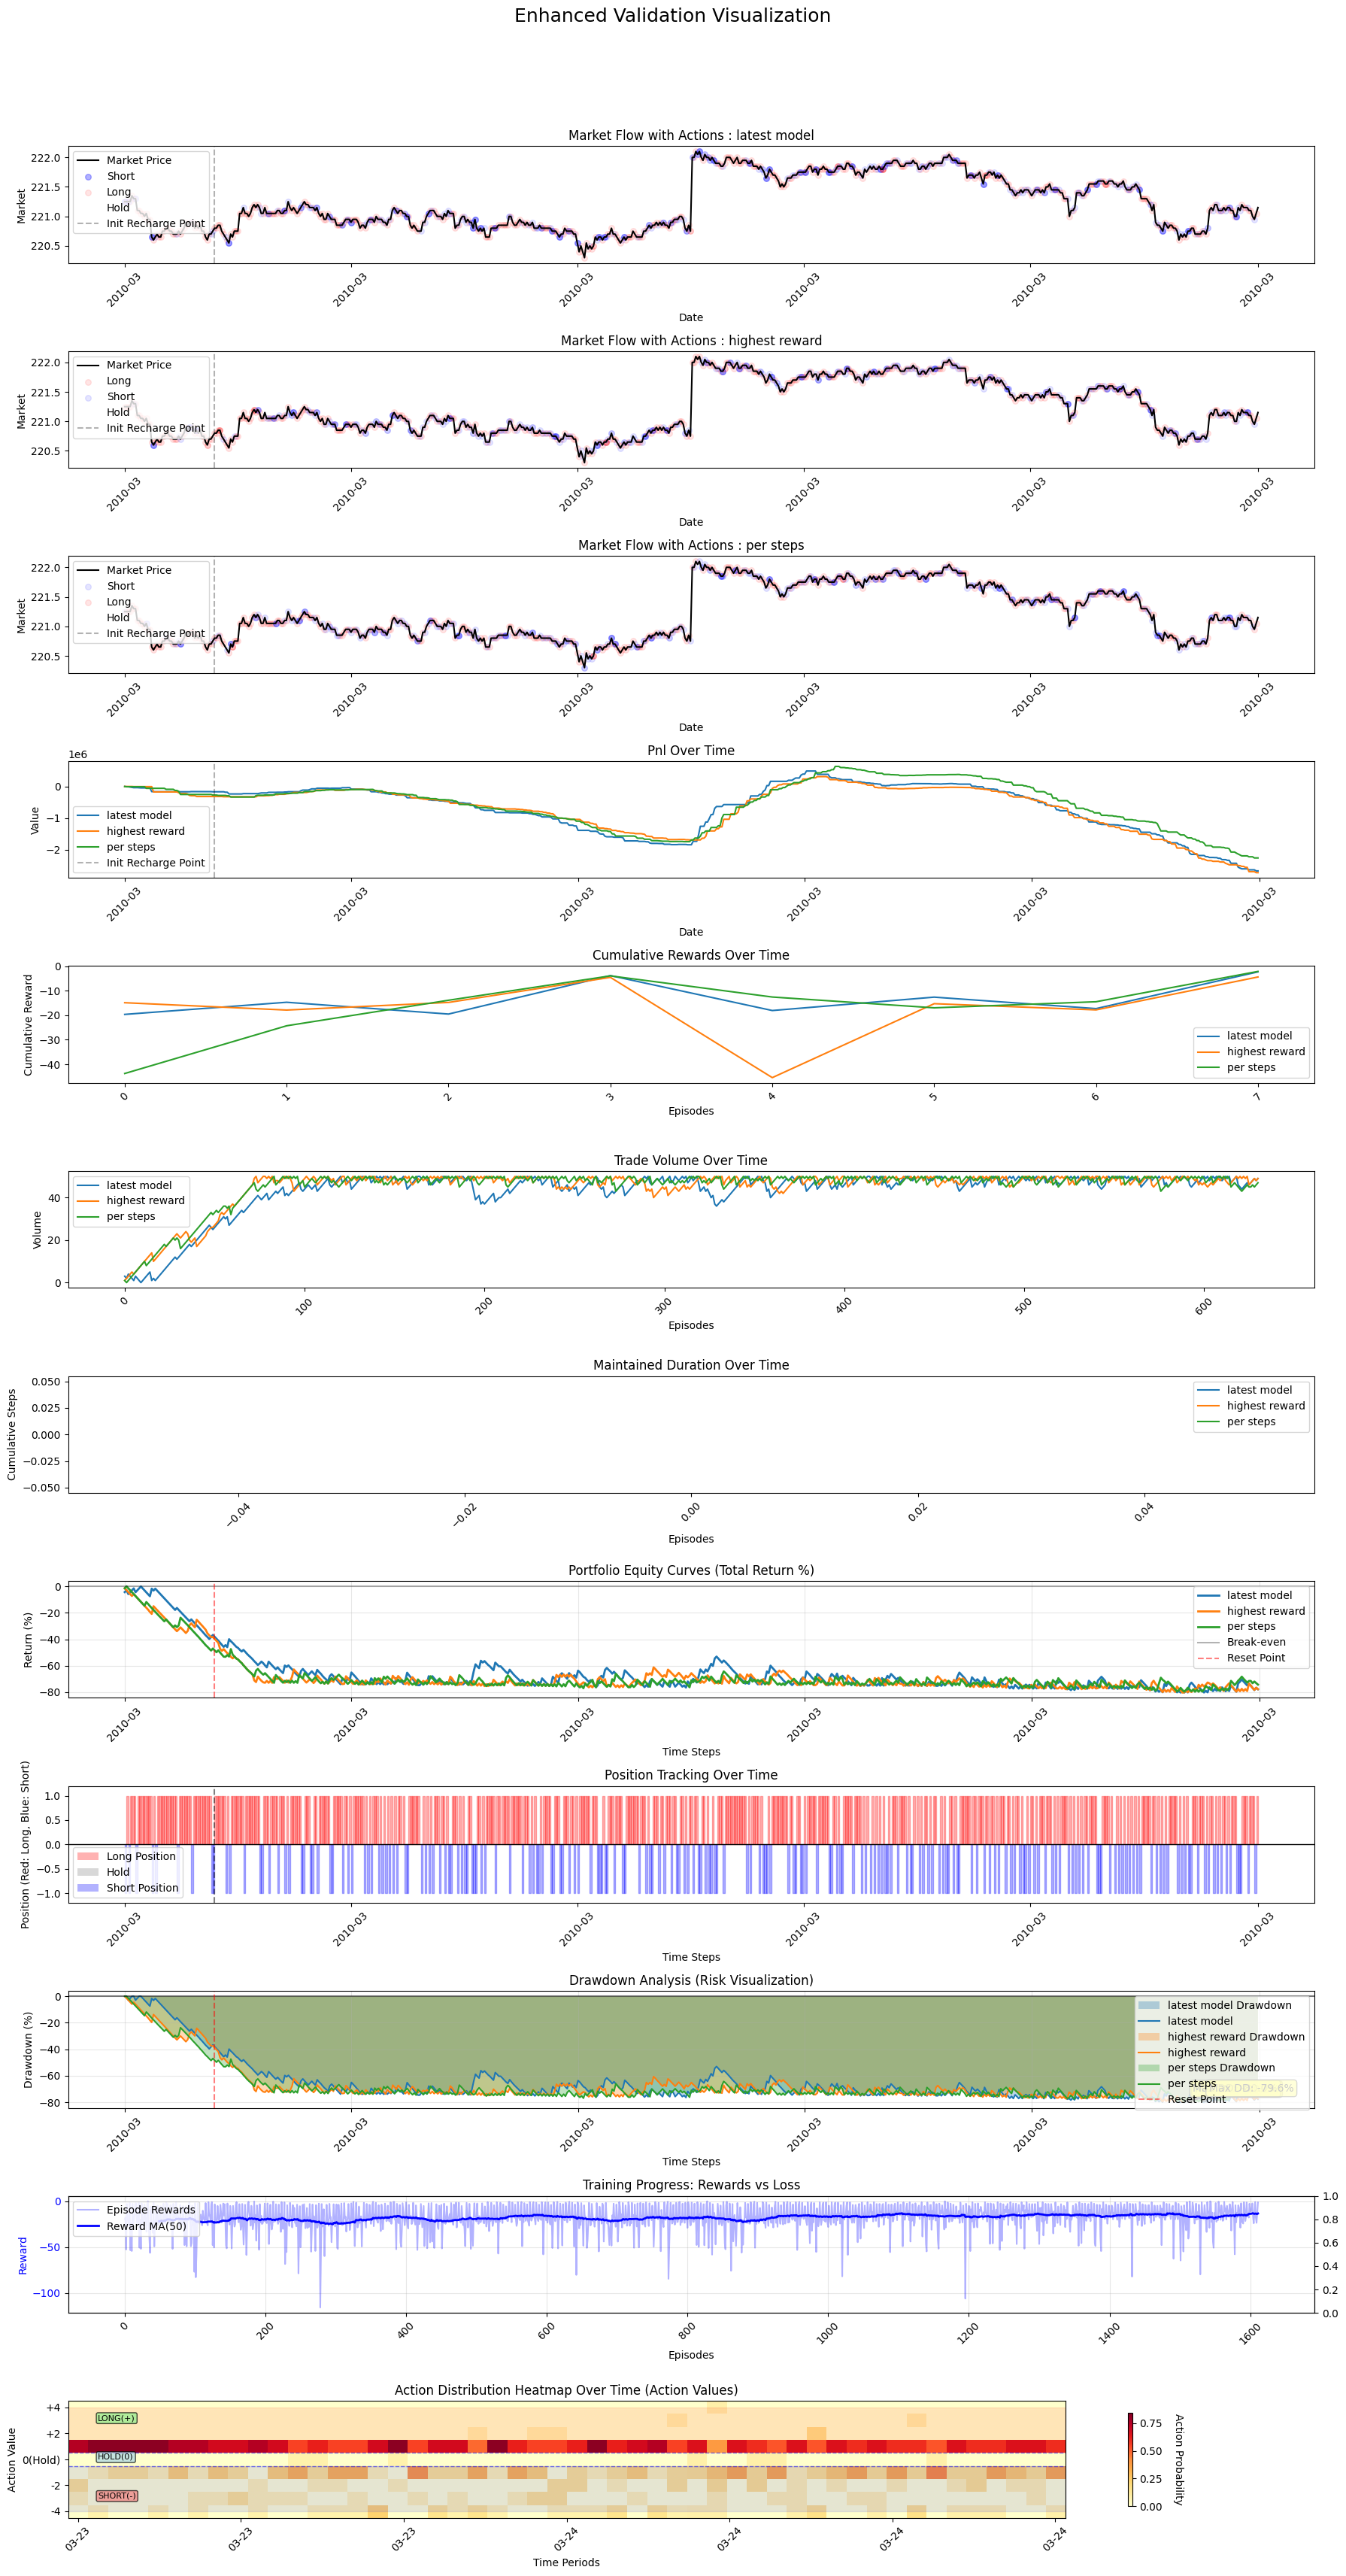

In [9]:
trainer = EpisodicTrainer( # NonEpisodicTrainer
    df=df,
    env=FuturesEnvironment,
    train_valid_timestep=CONFIG.TRAIN_VALID_TIMESTEP,
    window_size=CONFIG.WINDOW_SIZE,
    state=state,
    reward_ftn=CONFIG.REWARD_FTN,
    done_ftn=CONFIG.DONE_FTN,
    start_budget=CONFIG.START_BUDGET,
    scaler=CONFIG.SCALER,
    position_cap=CONFIG.POSITION_CAP,
    agent=agent,
    model=model,
    optimizer=optim.Adam,
    device=CONFIG.DEVICE,
    n_steps=CONFIG.N_STEPS,
    ma_interval=CONFIG.MA_INTERVAL,
    save_interval=CONFIG.SAVE_INTERVAL,
    path=CONFIG.PATH
)

trainer()